In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import random
import datetime

In [4]:
# --- Load Twitter Bot Detection CSV ---
bot_df = pd.read_csv('bot_detection_data.csv')

# Normalize/rename for consistency
bot_df = bot_df.rename(columns={'Bot Label': 'is_bot'})  # if needed
bot_df['is_bot'] = bot_df['is_bot'].astype(bool)

In [ ]:
# --- Simulated Retweet Network (retweeter → original author) ---
edges = [
    ('UserB', 'UserA'),
    ('UserC', 'UserA'),
    ('UserD', 'UserA'),
    ('UserE', 'UserB'),
    ('UserF', 'UserB'),
    ('UserG', 'UserC'),
    ('UserH', 'UserD'),
    ('UserI', 'UserA'),
    ('UserJ', 'UserE'),
    ('UserK', 'UserF'),
    ('UserL', 'UserG'),
    ('UserM', 'UserH'),
    ('UserN', 'UserA'),
    ('UserO', 'UserC'),
    ('UserP', 'UserA'),
    ('UserQ', 'UserI')
]

users = list(set([u for u, _ in edges] + [v for _, v in edges]))

# --- Add Metadata: followers_count, is_bot ---
# Merge real is_bot values from CSV where available; random for others
user_metadata = {}

for user in users:
    # Try to look up user in bot dataset
    bot_label = bot_df.loc[bot_df['User ID'] == user, 'is_bot']
    if not bot_label.empty:
        is_bot = bot_label.values[0]
    else:
        is_bot = random.choice([True, False])  # fallback if user not in CSV
    
    user_metadata[user] = {
        'followers_count': random.randint(100, 20000),
        'is_bot': is_bot
    }

In [8]:
# --- Simulate Tweet Data ---
tweet_data = []
base_time = datetime.datetime(2025, 10, 1, 8, 0, 0)
hashtags = ['#Launch2025', '#NewProduct', '#BrandX']

for idx, (retweeter, original_author) in enumerate(edges):
    tweet_data.append({
        'tweet_id': f'TW{1000+idx}',
        'user_id': retweeter,
        'retweeted_user_id': original_author,
        'timestamp': base_time + datetime.timedelta(minutes=random.randint(0, 300)),
        'retweet_count': random.randint(1, 100),
        'mentions': random.sample(users, k=random.randint(0, 2)),
        'campaign_hashtag': random.choice(hashtags)
    })

df_tweets = pd.DataFrame(tweet_data)

# --- Build Retweet Graph ---
G = nx.DiGraph()
G.add_edges_from([(row['user_id'], row['retweeted_user_id']) for _, row in df_tweets.iterrows()])

Top 3 important nodes:
        In-Degree  PageRank  Betweenness followers_count is_bot
UserA          6  0.320032     0.000000            9751   True
UserB          2  0.102902     0.016667            2011  False
UserC          2  0.084965     0.012500            6142  False


C:\Users\krist\AppData\Local\Temp\ipykernel_13160\642296748.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


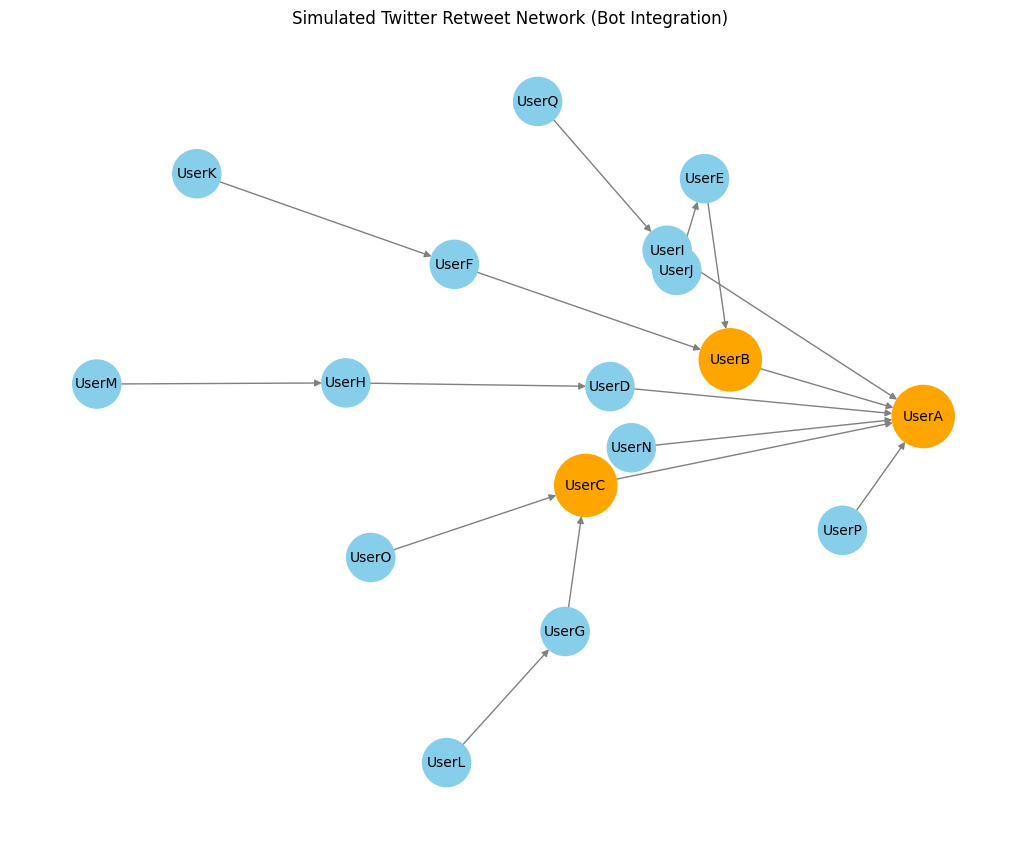

In [9]:
# --- Compute Centrality Measures ---
in_degree = dict(G.in_degree())
pagerank = nx.pagerank(G, alpha=0.85)
betweenness = nx.betweenness_centrality(G)

# --- Combine Centrality Metrics ---
df_metrics = pd.DataFrame({
    'In-Degree': pd.Series(in_degree),
    'PageRank': pd.Series(pagerank),
    'Betweenness': pd.Series(betweenness)
}).fillna(0)

# --- Merge with User Metadata (including is_bot from CSV) ---
user_meta_df = pd.DataFrame(user_metadata).T
user_meta_df.index.name = 'user_id'
df_final = df_metrics.join(user_meta_df, how='left')

# --- Display Top 3 Influencers by PageRank ---
top_nodes = df_final.sort_values('PageRank', ascending=False).head(3)
print("Top 3 important nodes:\n", top_nodes)

# --- Visualize the Network (highlighting top influencers) ---
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)

top_users = top_nodes.index.tolist()
node_colors = ['orange' if node in top_users else 'skyblue' for node in G.nodes()]
node_sizes = [2000 if node in top_users else 1200 for node in G.nodes()]

nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color='gray',
        node_size=node_sizes, font_size=10)
plt.title("Simulated Twitter Retweet Network (Bot Integration)")
plt.tight_layout()
plt.show()

In [10]:
# --- Sample Tweet Data Output ---
print("\nSample Tweet Data with All Fields:\n")
print(df_tweets.head())


Sample Tweet Data with All Fields:

  tweet_id user_id retweeted_user_id           timestamp  retweet_count  \
0   TW1000   UserB             UserA 2025-10-01 11:45:00             25   
1   TW1001   UserC             UserA 2025-10-01 08:12:00             35   
2   TW1002   UserD             UserA 2025-10-01 11:31:00             26   
3   TW1003   UserE             UserB 2025-10-01 11:53:00             62   
4   TW1004   UserF             UserB 2025-10-01 08:45:00             19   

         mentions campaign_hashtag  
0              []      #NewProduct  
1  [UserH, UserK]      #Launch2025  
2              []          #BrandX  
3  [UserH, UserM]      #Launch2025  
4  [UserM, UserK]      #Launch2025  
